In [34]:
import bokeh
import glob
import os
import pickle
import librosa
import warnings
import numpy as np
import pandas as pd
from bokeh.io import export_svgs
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure, show
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
bokeh.io.output_notebook()
warnings.filterwarnings('ignore')

Loading BokehJS ...

In [2]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.python.client import device_lib

In [3]:
def build_files_list(root_dir, normal_dir='normal', abnormal_dir='abnormal'):
    normal_files = []
    abnormal_files = []
    
    for root, dirs, files in os.walk(top=os.path.join(root_dir)):
        for name in files:
            current_dir_type = root.split('/')[-1]
            if current_dir_type == normal_dir:
                normal_files.append(os.path.join(root, name))
            if current_dir_type == abnormal_dir:
                abnormal_files.append(os.path.join(root, name))
                
    return normal_files, abnormal_files


def extract_signal_features(signal, sr, n_fft=1024, hop_length=512, n_mels=64, power=2.0, frames=5):
    mel_spectrogram = librosa.feature.melspectrogram(
        y=signal,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        power=power
    )
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    features_vector_size = log_mel_spectrogram.shape[1] - frames + 1
    dims = frames * n_mels
    
    if features_vector_size < 1:
        return np.empty((0, dims), np.float32)
    
    features = np.zeros((features_vector_size, dims), np.float32)
    for t in range(frames):
        features[:, n_mels * t: n_mels * (t + 1)] = log_mel_spectrogram[:, t:t + features_vector_size].T
        
    return features


def generate_dataset(files_list, n_fft=1024, hop_length=512, n_mels=64, power=2.0, frames=5):
    dims = n_mels * frames
    
    for index in tqdm(range(len(files_list))):
        signal, sr = load_sound_file(files_list[index])
        features = extract_signal_features(
            signal, 
            sr, 
            n_fft=n_fft, 
            hop_length=hop_length,
            n_mels=n_mels, 
            power=power,
            frames=frames
        )
        
        if index == 0:
            dataset = np.zeros((features.shape[0] * len(files_list), dims), np.float32)
            
        dataset[features.shape[0] * index : features.shape[0] * (index + 1), :] = features

    return dataset


def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']


def load_sound_file(path, mono=False, channel=0):
    signal, sr = librosa.load(path, sr=None, mono=mono)
    
    if signal.ndim < 2:
        return signal, sr
    else:
        return signal[channel, :], sr

In [14]:
DATA_PATH = '../../data/mimii-anomaly-detection'
IMAGE_PATH = './img'
MODEL_PATH = './models'

os.makedirs(os.path.join(DATA_PATH, 'dataset'), exist_ok=True)
os.makedirs(MODEL_PATH, exist_ok=True)

file_paths = sorted(glob.glob('{}/*/*'.format(DATA_PATH)))

file_path = file_paths[0]
suffix = '_'.join(['', file_path.split('/')[-2], file_path.split('/')[-2]])

In [5]:
normal_files, abnormal_files = build_files_list(root_dir=file_path)

X = np.concatenate((normal_files, abnormal_files), axis=0)
y = np.concatenate((np.zeros(len(normal_files)), np.ones(len(abnormal_files))), axis=0)

train_files, test_files, train_labels, test_labels = train_test_split(X, y, train_size=0.8, random_state=42, shuffle=True, stratify=y)

In [6]:
print('Train set has {} signals including abnormal {:.0f} signals, but test set has {} signals including abnormal {:.0f} signals.'.format(
    train_labels.shape[0], train_labels.sum(), test_labels.shape[0], test_labels.sum()))

Train set has 4440 signals including abnormal 1180 signals, but test set has 1110 signals including abnormal 295 signals.


In [7]:
dataset = {
    'train_files': train_files,
    'test_files': test_files,
    'train_labels': train_labels,
    'test_labels': test_labels
}

for key, values in dataset.items():
    file_name = os.path.join(DATA_PATH, 'dataset', key + suffix + '.txt')
    with open(file_name, 'w') as f:
        for item in values:
            f.write(str(item) + '\n')

In [8]:
train_files = [file for file in train_files if file not in abnormal_files]
train_labels = np.zeros(len(train_files))

n_fft = 2048
hop_length = 512
n_mels = 64
power = 2.0
frames = 5

train_data_path = os.path.join(DATA_PATH, 'dataset', 'train_data' + suffix + '.pkl')

if os.path.exists(train_data_path):
    print('Train data already exists, loading from file...')
    with open(train_data_path, 'rb') as f:
        train_data = pickle.load(f)
        
else:
    train_data = generate_dataset(train_files, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, power=power, frames=frames)
    print('Saving train data to disk...')
    with open(train_data_path, 'wb') as f:
        pickle.dump(train_data, f)
    print('Done.')

print(f'Train data has a {train_data.shape} shape.')

Train data already exists, loading from file...
Train data has a (1007340, 320) shape.


In [9]:
def autoencoder(input_dims):
    input_layer = Input(shape=(input_dims,))
    h = Dense(64, activation='relu')(input_layer)
    h = Dense(64, activation='relu')(h)
    h = Dense(8, activation='relu')(h)
    h = Dense(64, activation='relu')(h)
    h = Dense(64, activation='relu')(h)
    h = Dense(input_dims, activation=None)(h)
    
    return Model(inputs=input_layer, outputs=h, name='autoencoder')

In [10]:
np.random.seed(42)
tf.set_random_seed(42)

model = autoencoder(n_mels * frames)
print(model.summary())

gpu_count = len(get_available_gpus())
if gpu_count > 1:
    model = multi_gpu_model(model, gpus=gpu_count)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 320)]             0         
_________________________________________________________________
dense (Dense)                (None, 64)                20544     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
___

In [11]:
%%time
batch_size = 512
epochs = 200

model.compile(
    optimizer=Adam(learning_rate=1e-03),
    loss='mean_squared_error'
)

history = model.fit(
    train_data, 
    train_data,
    batch_size=batch_size,
    epochs=epochs,
    verbose=False,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)],
    validation_split=0.2,
    shuffle=True
)

model.save(os.path.join(MODEL_PATH, 'autoencoder' +  suffix + '.h5'))

CPU times: user 17min 6s, sys: 1min 50s, total: 18min 56s
Wall time: 7min 31s


In [92]:
p = figure(plot_width=600, plot_height=400, title='Model Loss', x_axis_label='# Epochs', y_axis_label='Loss')

source = ColumnDataSource(data=dict(index=range(len(history.history['loss'])), loss=history.history['loss'], val_loss=history.history['val_loss']))
_ = p.line('index', 'loss', color='crimson', line_dash='dotted', line_width=1.5, legend_label='Training Loss', source=source)
_ = p.line('index', 'val_loss', color='indigo', line_width=1.5, legend_label='Validation Loss', source=source)

p.xgrid.grid_line_color = None
p.legend.label_text_font_size = '8pt'
p.legend.location = 'top_right'
p.legend.click_policy = 'hide'
p.title.align = 'center'
p.title.text_font_size = '12pt'

p.add_tools(HoverTool(tooltips=[('epoch', '@index'), ('train loss', '@loss'), ('valid loss', '@val_loss')]))

show(p)
p.output_backend = 'svg'
_ = export_svgs(p, filename=os.path.join(IMAGE_PATH, 'model_loss.svg'))

In [27]:
reconstruction_errors = []

for index in tqdm(range(len(test_files))):
    signal, sr = load_sound_file(test_files[index])
    
    features = extract_signal_features(
        signal, 
        sr, 
        n_fft=n_fft, 
        hop_length=hop_length,
        n_mels=n_mels, 
        power=power,
        frames=frames
    )
    
    prediction = model.predict(features)
    mse = np.mean(np.mean(np.square(features - prediction), axis=1))
    reconstruction_errors.append(mse)

  0%|          | 0/1110 [00:00<?, ?it/s]

In [83]:
def get_histogram(data, bins=30):
    hist, edges = np.histogram(data, bins=bins)
    percent = list(map(lambda x: '{:.2%}'.format(x), hist / hist.sum()))
    alpha = hist / hist.sum() + 0.5 * (1.0 - np.max(hist) / hist.sum())

    df = pd.DataFrame({'count': hist, 'percent': percent, 'left': edges[:-1], 'right': edges[1:], 'alpha': alpha})
    df['interval'] = ['{0:.2f} to {1:.2f}'.format(left, right, n_digit) for left, right in zip(df['left'], df['right'])]
    return df

In [90]:
data = np.column_stack((range(len(reconstruction_errors)), reconstruction_errors))

p = figure(plot_width=600, plot_height=400, title='Reconstruction Error Distribution on the Test Set', 
           x_axis_label='Reconstruction Error', y_axis_label='# Samples')  

source = ColumnDataSource(get_histogram(data[y_true == 0][:, 1]))
p.quad(bottom=0.0, top='count', left='left', right='right', 
       fill_alpha='alpha', fill_color='crimson', line_color=None, line_width=0.6,
       hover_fill_alpha=1.0, hover_fill_color='tan', legend_label='Normal Signals', source=source)

source = ColumnDataSource(get_histogram(data[y_true == 1][:, 1]))

p.quad(bottom=0.0, top='count', left='left', right='right', 
       fill_alpha='alpha', fill_color='indigo', line_color=None, line_width=0.6,
       hover_fill_alpha=1.0, hover_fill_color='tan', legend_label='Abnormal Signals', source=source)

p.y_range.start = 0.0
p.legend.label_text_font_size = '8pt'
p.legend.location = 'top_right'
p.legend.click_policy = 'hide'
p.title.align = 'center'
p.title.text_font_size = '12pt'

p.add_tools(HoverTool(tooltips=[('interval', '@interval'), ('count', '@count'), ('percent', '@percent')]))

show(p)
p.output_backend = 'svg'
_ = export_svgs(p, filename=os.path.join(IMAGE_PATH, 'recon_error_dist.svg'))

In [ ]:
tag_count_by_playlist = pd.DataFrame(playlist_tag_map.groupby('id')['tags'].nunique())

hist, edges = np.histogram(tag_count_by_playlist, bins=10)
freq = list(map(lambda x: '{:.2%}'.format(x), hist / hist.sum()))
alpha = hist / hist.sum() + 0.5 * (1.0 - np.max(hist) / hist.sum())

hist = pd.DataFrame({'count': hist, 'freq': freq, 'left': edges[:-1], 'right': edges[1:], 'alpha': alpha})
hist['interval'] = ['%d to %d' % (left, right) for left, right in zip(hist['left'], hist['right'])]

source_of_hist = ColumnDataSource(hist)

p1 = figure(title='플레이리스트 별 태그 수 분포', x_axis_label='태그 수', y_axis_label='도수')  
p1.quad(bottom=0.0, top='count', left='left', right='right', 
       fill_color='crimson', line_color=None, fill_alpha='alpha', line_width=0.6,
       hover_fill_alpha=1.0, hover_fill_color='tan', source=source_of_hist)

median = tag_count_by_playlist.median().values[0]
source_of_med = ColumnDataSource(data=dict(interval=[median, median], count=[0, 30000], freq=['0.00%', '1.00%']))

p1.line('interval', 'count', line_color='black', line_width=1.0, line_dash='dashed', legend_label='중앙값', 
        source=source_of_med)

mean = tag_count_by_playlist.mean().values[0]
source_of_mean = ColumnDataSource(data=dict(interval=[mean, mean], count=[0, 30000], freq=['0.00%', '1.00%']))

p1.line('interval', 'count', line_color='black', line_width=1.0, line_dash='dotdash', legend_label='평균값', 
        source=source_of_mean)

hover = HoverTool(tooltips=[('interval', '@interval'), ('count', '@count'), ('freq', '@freq')])

p1.legend.label_text_font_size = '7pt'
p1.title.align = 'center'
p1.title.text_font_size = '10pt'
p1.y_range.start, p1.y_range.end = 0, 30000

p1.add_tools(hover)

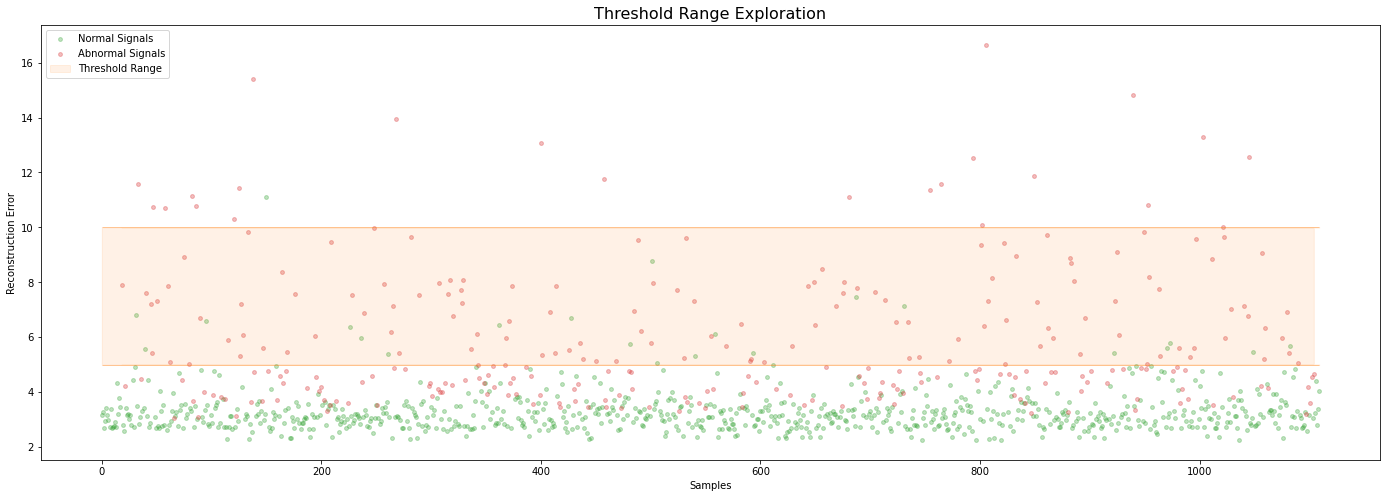

In [88]:
threshold_min = 5.0
threshold_max = 10.0
threshold_step = 0.50

normal_x, normal_y = data[y_true==0][:,0], data[y_true==0][:,1]
abnormal_x, abnormal_y = data[y_true==1][:,0], data[y_true==1][:,1]
x = np.concatenate((normal_x, abnormal_x))

fig, ax = plt.subplots(figsize=(24,8))
plt.scatter(normal_x, normal_y, s=15, color='tab:green', alpha=0.3, label='Normal Signals')
plt.scatter(abnormal_x, abnormal_y, s=15, color='tab:red', alpha=0.3, label='Abnormal Signals')
plt.fill_between(x, threshold_min, threshold_max, alpha=0.1, color='tab:orange', label='Threshold Range')
plt.hlines([threshold_min, threshold_max], x.min(), x.max(), linewidth=0.5, alpha=0.8, color='tab:orange')
plt.legend(loc='upper left')
plt.title('Threshold Range Exploration', fontsize=16)
plt.xlabel('Samples')
plt.ylabel('Reconstruction Error')
plt.show()

In [ ]:
def generate_error_types(df, ground_truth_col='Ground Truth', prediction_col='Prediction', normal_label=0.0, anomaly_label=1.0):
    """
    Compute false positive and false negatives columns based on the prediction
    and ground truth columns from a dataframe.
    
    PARAMS
    ======
        df (dataframe)
            Dataframe where the ground truth and prediction columns are available
        ground_truth_col (string)
            Column name for the ground truth values. Defaults to "Ground Truth"
        prediction_col (string)
            Column name for the predictied values. Defaults to "Prediction"
        normal_label (object)
            Value taken by a normal value. Defaults to 0.0
        anomaly_label (object)
            Value taken by an abnormal value. Defaults to 1.0
            
    RETURNS
    =======
        df (dataframe)
            An updated dataframe with 4 new binary columns for TP, TN, FP and FN.
    """
    df['TP'] = 0
    df['TN'] = 0
    df['FP'] = 0
    df['FN'] = 0
    df.loc[(df[ground_truth_col] == df[prediction_col]) & (df[ground_truth_col] == normal_label), 'TP'] = 1
    df.loc[(df[ground_truth_col] == df[prediction_col]) & (df[ground_truth_col] == anomaly_label), 'TN'] = 1
    df.loc[(df[ground_truth_col] != df[prediction_col]) & (df[ground_truth_col] == normal_label), 'FP'] = 1
    df.loc[(df[ground_truth_col] != df[prediction_col]) & (df[ground_truth_col] == anomaly_label), 'FN'] = 1
    
    return df

def plot_curves(FP, FN, nb_samples, threshold_min, threshold_max, threshold_step):
    """
    Plot the false positives and false negative samples number depending on a given threshold.
    
    PARAMS
    ======
        FP (dataframe)
            Number of false positives depending on the threshold
        FN (dataframe)
            Number of false negatives depending on the threshold
        threshold_min (float)
            Minimum threshold to plot for
        threshold_max (float)
            Maximum threshold to plot for
        threshold_step (float)
            Threshold step to plot these curves
    """
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1)
    
    min_FN = np.argmin(FN)
    min_FP = np.where(FP == np.min(FP))[0][-1]
    plot_top = max(FP + FN) + 1

    # Grid customization:
    major_ticks = np.arange(threshold_min, threshold_max, 1.0 * threshold_step)
    minor_ticks = np.arange(threshold_min, threshold_max, 0.2 * threshold_step)
    ax.set_xticks(major_ticks);
    ax.set_xticks(minor_ticks, minor=True);
    ax.grid(which='minor', alpha=0.5)
    ax.grid(which='major', alpha=1.0, linewidth=1.0)
    
    # Plot false positives and false negatives curves
    plt.plot(np.arange(threshold_min, threshold_max + threshold_step, threshold_step), FP, label='False positive', color='tab:red')
    plt.plot(np.arange(threshold_min, threshold_max + threshold_step, threshold_step), FN, label='False negative', color='tab:green')

    # Finalize the plot with labels and legend:
    plt.xlabel('Reconstruction error threshold (%)', fontsize=16)
    plt.ylabel('# Samples', fontsize=16)
    plt.legend()
    
    
def print_confusion_matrix(confusion_matrix, class_names, figsize = (4,3), fontsize=14):
    """
    Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix,
    as a heatmap.
    
    PARAMS
    ======
        confusion_matrix (numpy.ndarray)
            The numpy.ndarray object returned from a call to 
            sklearn.metrics.confusion_matrix. Similarly constructed 
            ndarrays can also be used.
        class_names (list)
            An ordered list of class names, in the order they index the given
            confusion matrix.
        figsize (tuple)
            A 2-long tuple, the first value determining the horizontal size of
            the ouputted figure, the second determining the vertical size.
            Defaults to (10,7).
        fontsize: (int)
            Font size for axes labels. Defaults to 14.
        
    RETURNS
    =======
        matplotlib.figure.Figure: The resulting confusion matrix figure
    """
    # Build a dataframe from the confusion matrix passed as argument:
    df_cm = pd.DataFrame(confusion_matrix, 
                         index=class_names, 
                         columns=class_names)
    
    # Plot the confusion matrix:
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}, cmap='viridis')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    # Figure customization:
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)
    
    return fig

In [ ]:
import pandas as pd
thresholds = np.arange(threshold_min, threshold_max + threshold_step, threshold_step)

df = pd.DataFrame(columns=['Signal', 'Ground Truth', 'Prediction', 'Reconstruction Error'])
df['Signal'] = test_files
df['Ground Truth'] = test_labels
df['Reconstruction Error'] = reconstruction_errors

FN = []
FP = []
for th in thresholds:
    df.loc[df['Reconstruction Error'] <= th, 'Prediction'] = 0.0
    df.loc[df['Reconstruction Error'] > th, 'Prediction'] = 1.0
    df = generate_error_types(df)
    FN.append(df['FN'].sum())
    FP.append(df['FP'].sum())
        
plot_curves(FP, FN, nb_samples=df.shape[0], threshold_min=threshold_min, threshold_max=threshold_max, threshold_step=threshold_step)

In [ ]:
import seaborn as sns

th = 6.275
df.loc[df['Reconstruction Error'] <= th, 'Prediction'] = 0.0
df.loc[df['Reconstruction Error'] > th, 'Prediction'] = 1.0
df['Prediction'] = df['Prediction'].astype(np.float32)
df = generate_error_types(df)
tp = df['TP'].sum()
tn = df['TN'].sum()
fn = df['FN'].sum()
fp = df['FP'].sum()

from sklearn.metrics import confusion_matrix
df['Ground Truth'] = 1 - df['Ground Truth']
df['Prediction'] = 1 - df['Prediction']
print_confusion_matrix(confusion_matrix(df['Ground Truth'], df['Prediction']), class_names=['abnormal', 'normal']);



In [ ]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
accuracy = (tp + tn) / (tp + tn + fp + fn)
f1_score = 2 * precision * recall / (precision + recall)

print(f"""Basic autoencoder metrics:
- Precision: {precision*100:.1f}%
- Recall: {recall*100:.1f}%
- Accuracy: {accuracy*100:.1f}%
- F1 Score: {f1_score*100:.1f}%""")



In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_true, reconstruction_errors)

In [ ]:
class visualizer(object):
    def __init__(self):
        import matplotlib.pyplot as plt
        self.plt = plt
        self.fig = self.plt.figure(figsize=(30, 10))
        self.plt.subplots_adjust(wspace=0.3, hspace=0.3)

    def loss_plot(self, loss, val_loss):
        """
        Plot loss curve.
        loss : list [ float ]
            training loss time series.
        val_loss : list [ float ]
            validation loss time series.
        return   : None
        """
        ax = self.fig.add_subplot(1, 1, 1)
        ax.cla()
        ax.plot(loss)
        ax.plot(val_loss)
        ax.set_title("Model loss")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.legend(["Train", "Test"], loc="upper right")

    def save_figure(self, name):
        """
        Save figure.
        name : str
            save .png file path.
        return : None
        """
        self.plt.savefig(name)

In [ ]:
visualizer().loss_plot(history.history["loss"], history.history["val_loss"])
# visualizer.save_figure(history_img)

In [ ]:
training_input_path = sagemaker.Session().upload_data(os.path.join(DATA_PATH, 'dataset', 'train_data_' + suffix + '.pkl'), key_prefix='training')
print(training_input_path)

In [ ]:
from sagemaker.tensorflow import TensorFlow

tf_estimator = TensorFlow(
    base_job_name='sound-anomaly',
    entry_point='model.py',
    source_dir='.',
    role='AmazonSageMaker-ExecutionRole-20210114T163887',
    instance_count=1, 
    instance_type='ml.m5.24xlarge',
    framework_version='2.2',
    py_version='py37',
    hyperparameters={
        'epochs': 30,
        'batch-size': 512,
        'learning-rate': 1e-3,
        'n_mels': n_mels,
        'frame': frames
    },
    debugger_hook_config=False
)

In [ ]:
tf_estimator.fit({'training': training_input_path})

In [ ]:
tf_endpoint_name = 'sound-anomaly-'+time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
tf_predictor = tf_estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.c5.large',
    endpoint_name=tf_endpoint_name
)
print(f'\nEndpoint name: {tf_predictor.endpoint_name}')